In [ ]:
import tensorflow as tf
from tensorflow.keras.models import save_model
#from tensorflow.python.framework import ops
import tensorflow.keras.layers as L
#import tensorflow.compat.v1.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
#import keras_utils
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
# Normalize the pixel values to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

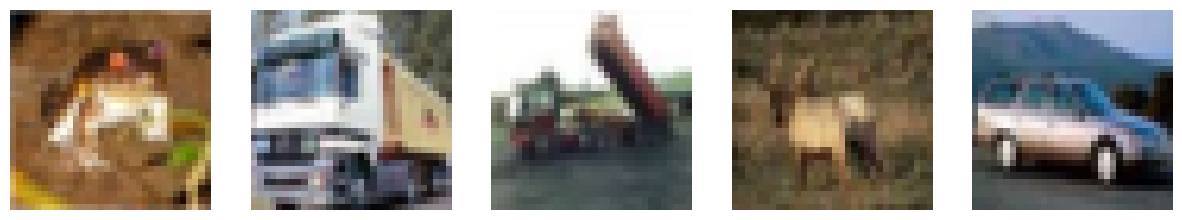

In [ ]:
import matplotlib.pyplot as plt

# Specify the number of images you want to display
num_images_to_display = 5

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

# Loop through and display the images
for i in range(num_images_to_display):
    axes[i].imshow(x_train[i])  # Display the image
    axes[i].axis('off')  # Turn off axis labels

# Show the images
plt.show()

In [ ]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape

    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))

    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))

    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2, 2, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder

In [ ]:
IMG_SHAPE = x_train.shape[1:]
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    tf.keras.backend.clear_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"

    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [ ]:
tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [ ]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [ ]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [ ]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

In [ ]:
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [ ]:
autoencoder.fit(x=x_train, y=x_train, epochs=25,
                validation_data=[x_test, x_test],
                callbacks=[ModelSaveCallback(model_filename)],
                           #keras_utils.TqdmProgressCallback()],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

Epoch 1/25
1563/1563 [==============================] - 26s 8ms/step - loss: 0.0231 - val_loss: 0.0144
Epoch 2/25
  18/1563 [..............................] - ETA: 9s - loss: 0.0140 

<ipython-input-12-edd667ebc108>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, model_filename)


1563/1563 [==============================] - 12s 7ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 3/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 4/25
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 5/25
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 6/25
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 7/25
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 8/25
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 9/25
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 10/25
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 11/25
1563/1563 [==============================] - 12s 7ms/step - loss: 0.011

In [ ]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()

In [ ]:
code = encoder.predict(x_test)
reco = decoder.predict(code)[0]

In [ ]:
from skimage.metrics import structural_similarity as ssim
#Calculate MSE
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=0)
# Calculate SSIM
ssim_value, _ = ssim(x_test, reco, full=True, multichannel=True)
print("Convolutional autoencoder MSE:", reconstruction_mse)
print(f"SSIM: {ssim_value:.4f}")

<ipython-input-19-2721ddab2192>:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value, _ = ssim(x_test, reco, full=True, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Convolutional autoencoder MSE: 0.011413762345910072
SSIM: 0.8616


1/1 [==============================] - 0s 151ms/step


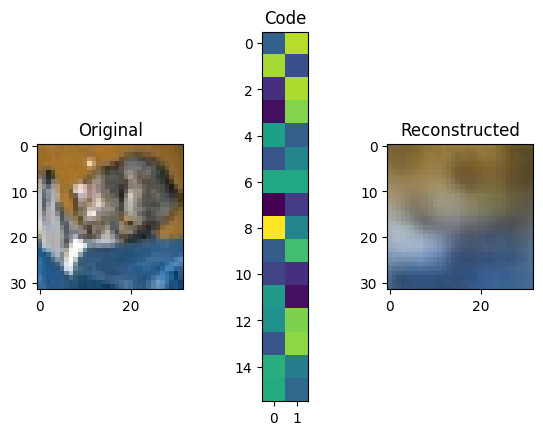

1/1 [==============================] - 0s 17ms/step


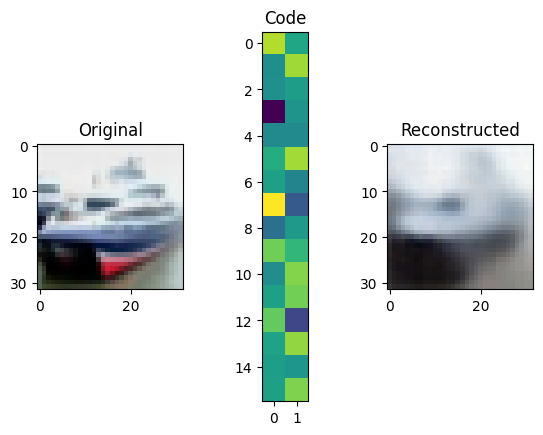

1/1 [==============================] - 0s 16ms/step


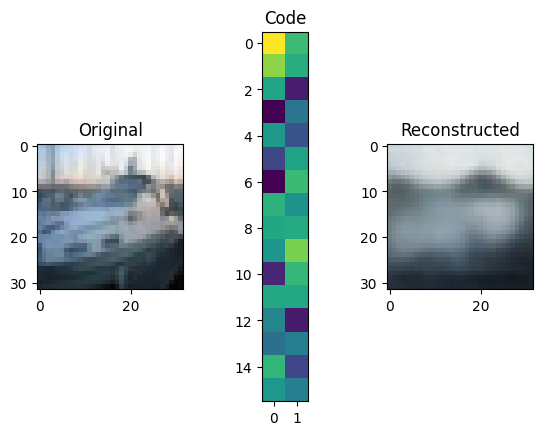

1/1 [==============================] - 0s 16ms/step


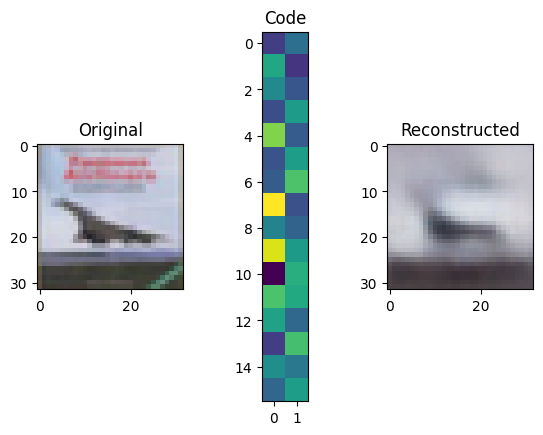

1/1 [==============================] - 0s 28ms/step


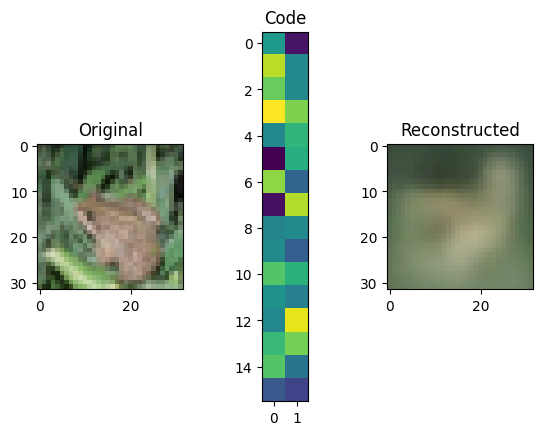

In [ ]:
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [ ]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [ ]:
# restore trained weights
tf.keras.backend.clear_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(x_test, x_test, verbose=1))
print(reconstruction_mse)

313/313 [==============================] - 1s 4ms/step - loss: 0.0114
0.011441455222666264
0.011441455222666264


In [ ]:
import tensorflow as tf

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist

# Load the dataset into train and test sets
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1 = x_train1 / 255.0
x_test1 = x_test1 / 255.0


11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize the pixel values to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

169001437/169001437 [==============================] - 11s 0us/step


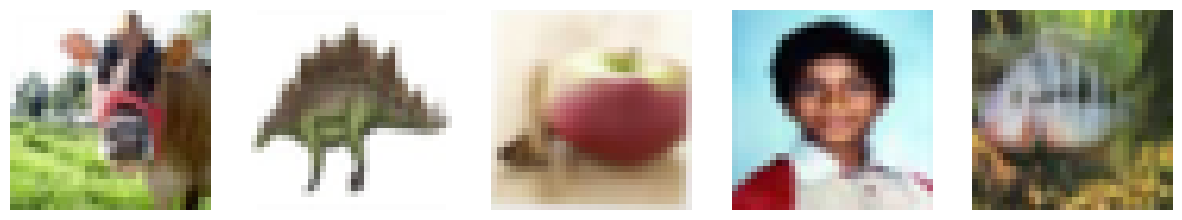

In [ ]:
import matplotlib.pyplot as plt

# Specify the number of images you want to display
num_images_to_display = 5

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

# Loop through and display the images
for i in range(num_images_to_display):
    axes[i].imshow(x_train[i])  # Display the image
    axes[i].axis('off')  # Turn off axis labels

# Show the images
plt.show()

In [ ]:
IMG_SHAPE = x_train.shape[1:]
print(IMG_SHAPE)

(32, 32, 3)


In [ ]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    tf.keras.backend.clear_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"

    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [ ]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [ ]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [ ]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:02d}.hdf5'
last_finished_epoch = None

In [ ]:
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [ ]:
autoencoder.fit(x=x_train, y=x_train, epochs=25,
                validation_data=[x_test, x_test],
                callbacks=[ModelSaveCallback(model_filename)],
                           #keras_utils.TqdmProgressCallback()],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

Epoch 1/25
1563/1563 [==============================] - 14s 8ms/step - loss: 0.0199 - val_loss: 0.0117
Epoch 2/25
  18/1563 [..............................] - ETA: 9s - loss: 0.0115

<ipython-input-31-edd667ebc108>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, model_filename)


1563/1563 [==============================] - 11s 7ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 3/25
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 4/25
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 5/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 6/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 7/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 8/25
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 10/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 11/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.003

Convolutional autoencoder MSE: 0.0028172084130346775
1/1 [==============================] - 0s 100ms/step


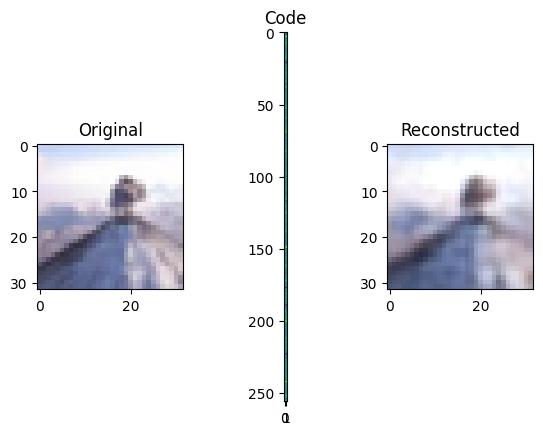

1/1 [==============================] - 0s 19ms/step


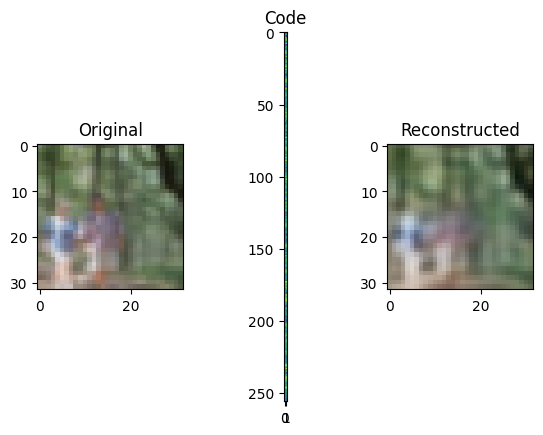

1/1 [==============================] - 0s 16ms/step


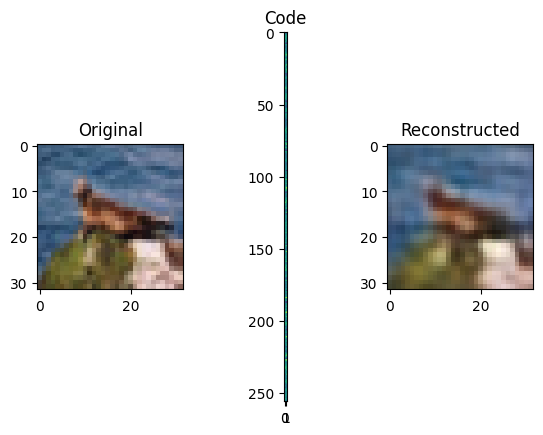

1/1 [==============================] - 0s 16ms/step


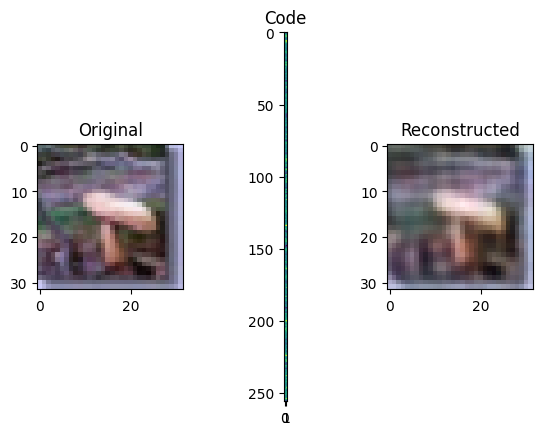

1/1 [==============================] - 0s 15ms/step


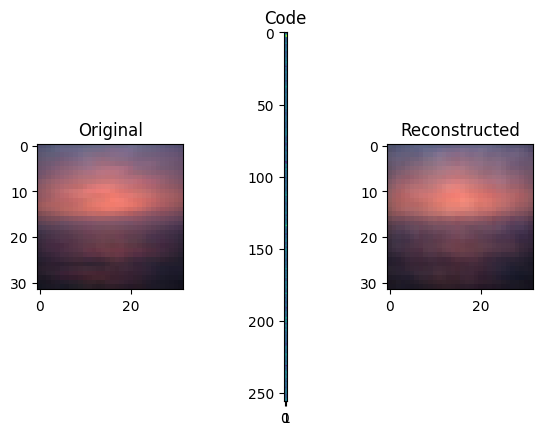

In [ ]:
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [ ]:
# save trained weights
encoder.save_weights("encoder1.h5")
decoder.save_weights("decoder1.h5")

In [ ]:
# restore trained weights
tf.keras.backend.clear_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder1.h5")
decoder.load_weights("decoder1.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(x_test, x_test, verbose=1))
print(reconstruction_mse)

313/313 [==============================] - 1s 4ms/step - loss: 0.3022
0.30223000049591064
0.0028172084130346775
